In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from collections import Counter
from typing import Dict, List, Tuple, Union
import numpy.typing as npt

def syllable_to_phrase_labels(arr, silence=-1):
    new_arr = np.array(arr, dtype=int)
    current_syllable = None
    start_of_phrase_index = None
    first_non_silence_label = None  # To track the first non-silence syllable

    for i, value in enumerate(new_arr):
        if value != silence and value != current_syllable:
            if start_of_phrase_index is not None:
                new_arr[start_of_phrase_index:i] = current_syllable
            current_syllable = value
            start_of_phrase_index = i
            
            if first_non_silence_label is None:  # Found the first non-silence label
                first_non_silence_label = value

    if start_of_phrase_index is not None:
        new_arr[start_of_phrase_index:] = current_syllable

    # Replace the initial silence with the first non-silence syllable label
    if new_arr[0] == silence and first_non_silence_label is not None:
        for i in range(len(new_arr)):
            if new_arr[i] != silence:
                break
            new_arr[i] = first_non_silence_label

    return new_arr

def smooth_labels(labels, window_size=50):
    labels = np.array(labels)
    for i in range(len(labels)):
        if labels[i] == -1:
            left = right = i
            while left >= 0 or right < len(labels):
                if left >= 0 and labels[left] != -1:
                    labels[i] = labels[left]
                    break
                if right < len(labels) and labels[right] != -1:
                    labels[i] = labels[right]
                    break
                left -= 1
                right += 1
    
    smoothed_labels = np.zeros_like(labels)
    for i in range(len(labels)):
        start = max(0, i - window_size // 2)
        end = min(len(labels), i + window_size // 2 + 1)
        window = labels[start:end]
        unique, counts = np.unique(window, return_counts=True)
        smoothed_labels[i] = unique[np.argmax(counts)]
    return smoothed_labels

class SequenceAnalyzer:
    @staticmethod
    def create_shared_area_matrix(ground_truth: npt.NDArray, 
                                predicted: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray, npt.NDArray]:
        """Create and normalize shared area matrix between ground truth and predicted labels."""
        unique_ground_truth = np.unique(ground_truth)
        unique_predicted = np.unique(predicted)
        
        # Create shared area matrix
        shared_matrix = np.zeros((len(unique_ground_truth), len(unique_predicted)))
        
        for i, gt_label in enumerate(unique_ground_truth):
            for j, pred_label in enumerate(unique_predicted):
                shared_matrix[i, j] = np.sum((ground_truth == gt_label) & 
                                           (predicted == pred_label))
        
        # Normalize rows
        row_sums = shared_matrix.sum(axis=1, keepdims=True)
        normalized_matrix = np.divide(shared_matrix, row_sums, 
                                    where=row_sums != 0)
        
        return normalized_matrix, unique_ground_truth, unique_predicted

    @staticmethod
    def find_optimal_mapping(normalized_matrix: npt.NDArray,
                           unique_ground_truth: npt.NDArray,
                           unique_predicted: npt.NDArray) -> Tuple[Dict[int, int], npt.NDArray, npt.NDArray]:
        """Find optimal mapping between predicted and ground truth labels."""
        cost_matrix = -normalized_matrix
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # Create mapping dictionary
        mapping = {unique_predicted[col]: unique_ground_truth[row]
                  for row, col in zip(row_ind, col_ind)}
        
        # Map unmapped labels to noise (-1)
        all_predicted = set(unique_predicted)
        mapped_predicted = set(mapping.keys())
        for label in (all_predicted - mapped_predicted):
            mapping[label] = -1
            
        return mapping, row_ind, col_ind

    @staticmethod
    def evaluate_mapping(ground_truth: npt.NDArray, 
                        predicted: npt.NDArray,
                        mapping: Dict[int, int]) -> Tuple[int, float]:
        """Evaluate mapping quality."""
        remapped = np.array([mapping[label] for label in predicted])
        differences = np.sum(remapped != ground_truth)
        difference_percentage = (differences / len(ground_truth)) * 100
        return differences, difference_percentage

    @staticmethod
    def visualize_mapping(normalized_matrix: npt.NDArray,
                         row_ind: npt.NDArray,
                         col_ind: npt.NDArray,
                         unique_ground_truth: npt.NDArray,
                         unique_predicted: npt.NDArray,
                         title: str) -> None:
        """Visualize the mapping matrix."""
        optimal_matrix = normalized_matrix[row_ind][:, col_ind]
        optimal_ground_truth = unique_ground_truth[row_ind]
        optimal_predicted = unique_predicted[col_ind]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(optimal_matrix, annot=False, cmap="viridis",
                   xticklabels=optimal_predicted,
                   yticklabels=optimal_ground_truth)
        plt.xlabel('HDBSCAN Labels')
        plt.ylabel('Ground Truth Phrase Labels')
        plt.title(f'Optimally Arranged Normalized Shared Area Matrix\n{title}')
        plt.show()

# Process the files
files = ["files/llb3.npz", "files/llb11.npz", "files/llb16.npz"]
analyzer = SequenceAnalyzer()

for file in files:
    # Load data
    data = np.load(file)
    ground_truth_labels = data['ground_truth_labels']
    hdbscan_labels = data['hdbscan_labels']
    
    # Process labels using your functions
    hdbscan_labels = smooth_labels(hdbscan_labels, window_size=0)
    ground_truth_phrase_labels = syllable_to_phrase_labels(ground_truth_labels, silence=0)
    
    # Create shared area matrix
    normalized_matrix, unique_ground_truth, unique_predicted = analyzer.create_shared_area_matrix(
        ground_truth_phrase_labels, hdbscan_labels)
    
    # Find optimal mapping
    mapping, row_ind, col_ind = analyzer.find_optimal_mapping(
        normalized_matrix, unique_ground_truth, unique_predicted)
    
    # Evaluate mapping
    differences, difference_percentage = analyzer.evaluate_mapping(
        ground_truth_phrase_labels, hdbscan_labels, mapping)
    
    # Print results
    print(f"\nFile: {file}")
    print(f"Number of differences: {differences}")
    print(f"Percentage of differences: {difference_percentage:.2f}%")
    
    # Visualize results
    analyzer.visualize_mapping(
        normalized_matrix, row_ind, col_ind,
        unique_ground_truth, unique_predicted,
        f"File: {file}"
    )


File: files/llb3.npz
Original Hungarian method:
  Number of differences: 289727
  Percentage of differences: 28.97%
Merged mapping method:
  Number of differences: 277133
  Percentage of differences: 27.71%


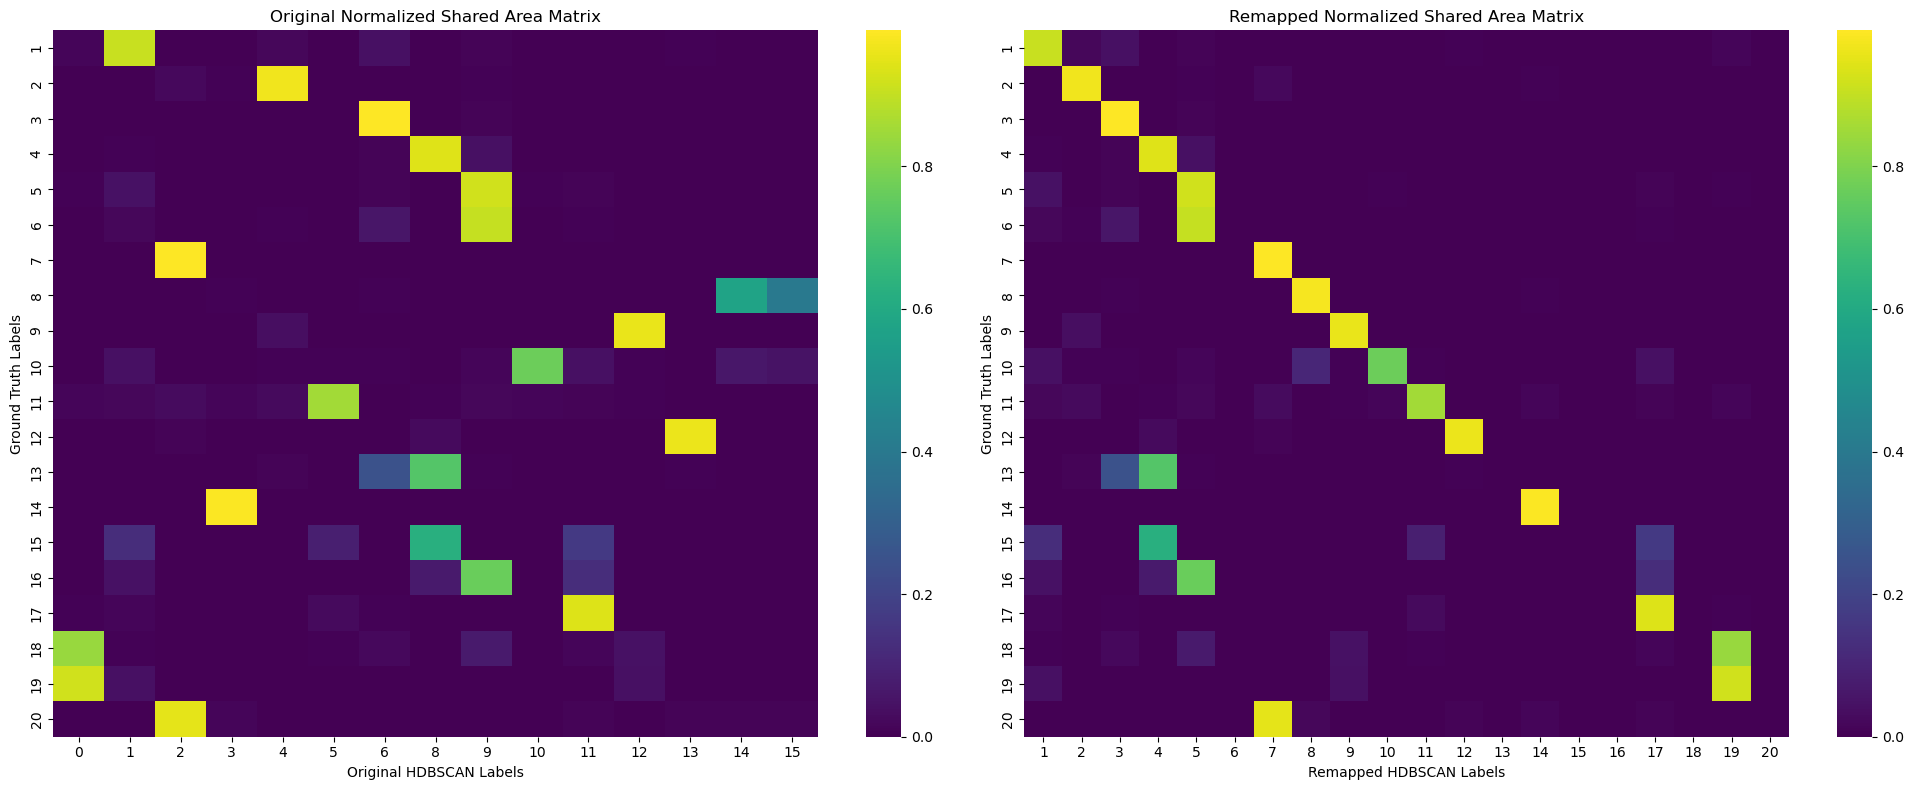


File: files/llb11.npz
Original Hungarian method:
  Number of differences: 150667
  Percentage of differences: 15.07%
Merged mapping method:
  Number of differences: 150667
  Percentage of differences: 15.07%


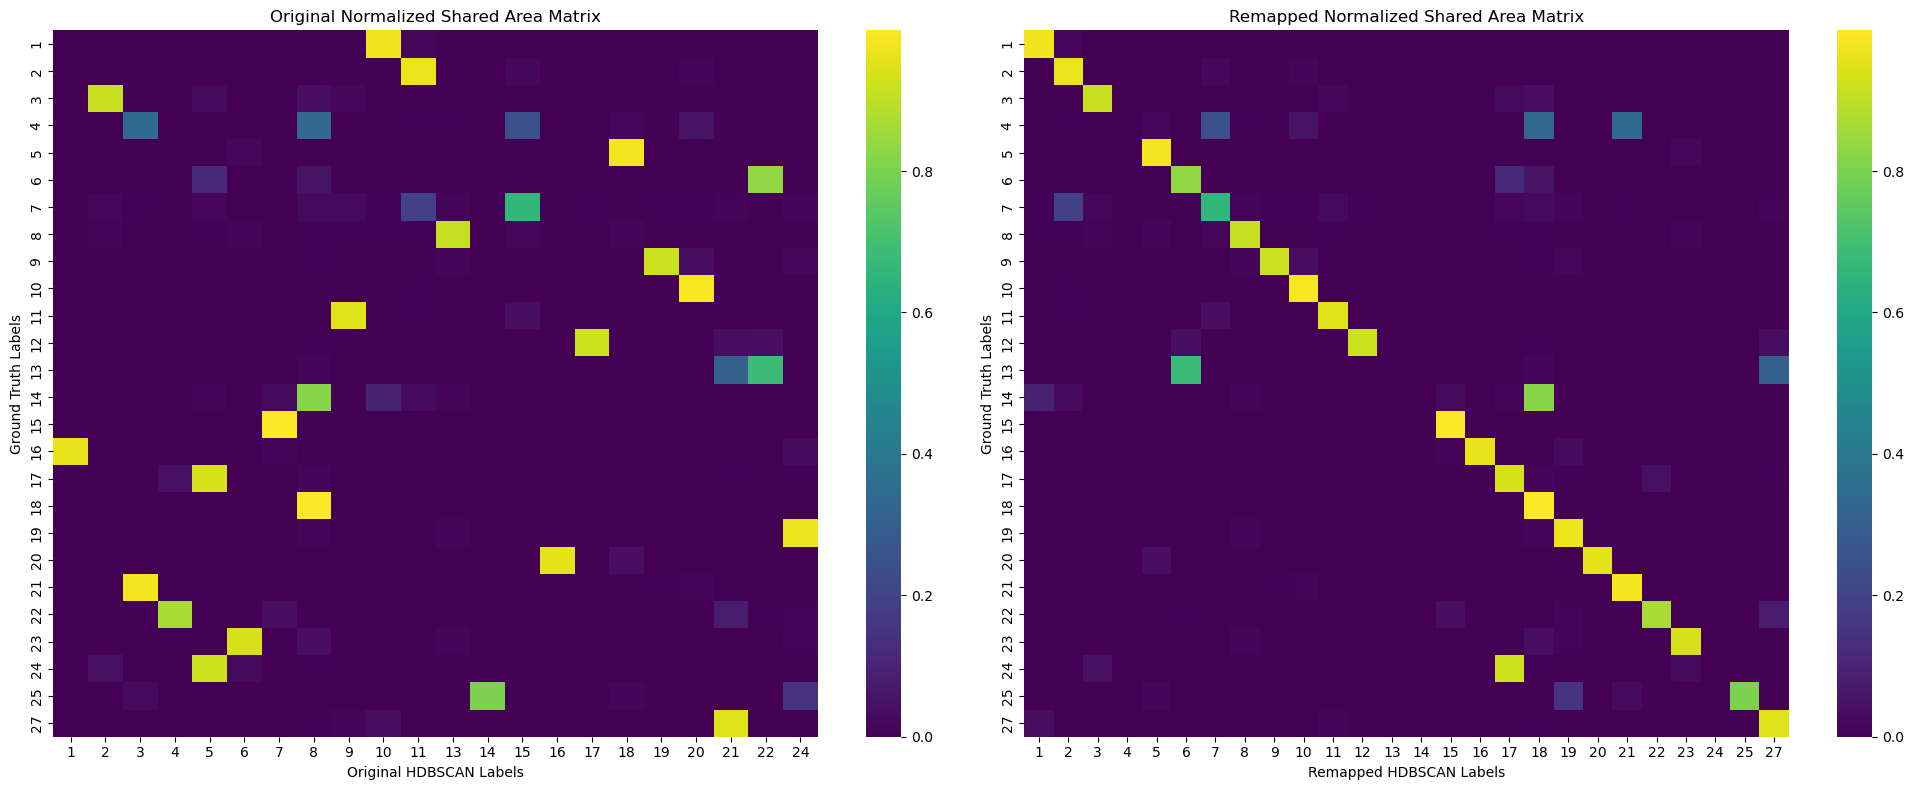


File: files/llb16.npz
Original Hungarian method:
  Number of differences: 236047
  Percentage of differences: 23.60%
Merged mapping method:
  Number of differences: 188206
  Percentage of differences: 18.82%


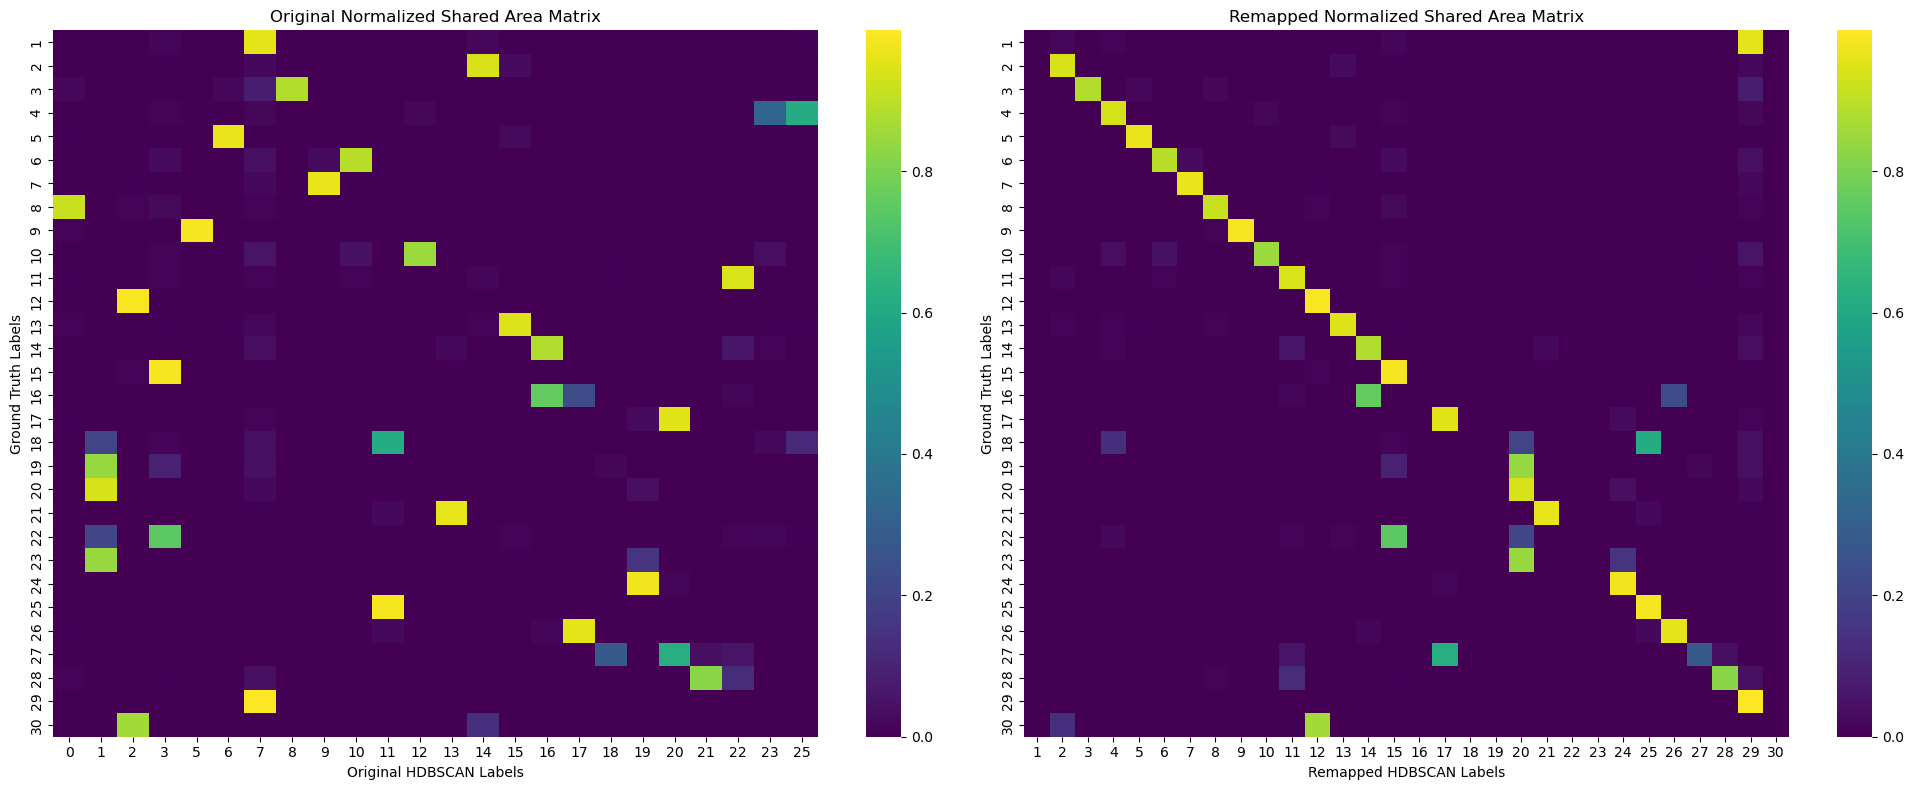

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def create_merged_label_mapping(normalized_matrix, unique_ground_truth_labels, unique_hdbscan_labels):
    """
    Creates a mapping that allows multiple HDBSCAN labels to map to a single ground truth label
    when that ground truth label is the best match for each HDBSCAN label.
    """
    col_sums = normalized_matrix.sum(axis=0, keepdims=True)
    col_normalized_matrix = normalized_matrix / col_sums
    
    label_mapping = {}
    for hdbscan_idx, hdbscan_label in enumerate(unique_hdbscan_labels):
        best_match_idx = np.argmax(col_normalized_matrix[:, hdbscan_idx])
        label_mapping[hdbscan_label] = unique_ground_truth_labels[best_match_idx]
    
    return label_mapping

for file in files:
    data = np.load(file)
    
    ground_truth_labels = data['ground_truth_labels']
    hdbscan_labels = data['hdbscan_labels']
    
    hdbscan_labels = smooth_labels(hdbscan_labels, window_size=0)
    ground_truth_phrase_labels = syllable_to_phrase_labels(ground_truth_labels, silence=0)
    
    # Create shared area matrix
    unique_ground_truth_labels = np.unique(ground_truth_phrase_labels)
    unique_hdbscan_labels = np.unique(hdbscan_labels)
    shared_area_matrix = np.zeros((len(unique_ground_truth_labels), len(unique_hdbscan_labels)))
    
    for i, ground_truth_label in enumerate(unique_ground_truth_labels):
        for j, hdbscan_label in enumerate(unique_hdbscan_labels):
            shared_area_matrix[i, j] = np.sum((ground_truth_phrase_labels == ground_truth_label) &
                                            (hdbscan_labels == hdbscan_label))
    
    # Normalize matrix
    row_sums = shared_area_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = shared_area_matrix / row_sums
    
    # Original Hungarian method for comparison
    cost_matrix = -normalized_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    original_mapping = {unique_hdbscan_labels[col]: unique_ground_truth_labels[row]
                       for row, col in zip(row_ind, col_ind)}
    # Map any unassigned labels to -1
    for label in unique_hdbscan_labels:
        if label not in original_mapping:
            original_mapping[label] = -1
    original_remapped = np.array([original_mapping[label] for label in hdbscan_labels])
    
    # Calculate original error
    original_differences = np.sum(original_remapped != ground_truth_phrase_labels)
    original_difference_percentage = (original_differences / len(ground_truth_phrase_labels)) * 100
    
    # New merged mapping
    merged_mapping = create_merged_label_mapping(
        normalized_matrix,
        unique_ground_truth_labels,
        unique_hdbscan_labels
    )
    
    # Calculate merged mapping error
    merged_remapped = np.array([merged_mapping[label] for label in hdbscan_labels])
    merged_differences = np.sum(merged_remapped != ground_truth_phrase_labels)
    merged_difference_percentage = (merged_differences / len(ground_truth_phrase_labels)) * 100
    
    print(f"\nFile: {file}")
    print(f"Original Hungarian method:")
    print(f"  Number of differences: {original_differences}")
    print(f"  Percentage of differences: {original_difference_percentage:.2f}%")
    print(f"Merged mapping method:")
    print(f"  Number of differences: {merged_differences}")
    print(f"  Percentage of differences: {merged_difference_percentage:.2f}%")
    
    # Create remapped matrix for visualization
    remapped_matrix = np.zeros((len(unique_ground_truth_labels), len(unique_ground_truth_labels)))
    for i, gt_label in enumerate(unique_ground_truth_labels):
        for j, hdbscan_label in enumerate(unique_hdbscan_labels):
            gt_idx = np.where(unique_ground_truth_labels == merged_mapping[hdbscan_label])[0][0]
            remapped_matrix[i, gt_idx] += shared_area_matrix[i, j]
    
    # Normalize remapped matrix
    row_sums = remapped_matrix.sum(axis=1, keepdims=True)
    normalized_remapped_matrix = remapped_matrix / row_sums
    
    # Plot both matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Original matrix
    sns.heatmap(normalized_matrix, annot=False, cmap="viridis",
                xticklabels=unique_hdbscan_labels,
                yticklabels=unique_ground_truth_labels, ax=ax1)
    ax1.set_xlabel('Original HDBSCAN Labels')
    ax1.set_ylabel('Ground Truth Labels')
    ax1.set_title('Original Normalized Shared Area Matrix')
    
    # Remapped matrix
    sns.heatmap(normalized_remapped_matrix, annot=False, cmap="viridis",
                xticklabels=unique_ground_truth_labels,
                yticklabels=unique_ground_truth_labels, ax=ax2)
    ax2.set_xlabel('Remapped HDBSCAN Labels')
    ax2.set_ylabel('Ground Truth Labels')
    ax2.set_title('Remapped Normalized Shared Area Matrix')
    
    plt.tight_layout()
    plt.show()

In [ ]:
    plt.figure(figsize=(12, 8))
    
    for window_size in smoothing_window_length:
        smoothed_ground_truth_labels = smooth_labels(ground_truth_phrase_labels, window_size=window_size)
        state_durations = calculate_state_durations(smoothed_ground_truth_labels)
        unique_states, counts = np.unique(smoothed_ground_truth_labels, return_counts=True)

        # Calculate average durations for each unique state
        avg_durations = []
        current_idx = 0

        # Iterate through each unique state and calculate durations
        for state in unique_states:
            state_durations_for_state = []
            current_duration = 0

            # Traverse through smoothed labels to get durations of the current state
            for i in range(len(smoothed_ground_truth_labels)):
                if smoothed_ground_truth_labels[i] == state:
                    current_duration += 1
                elif current_duration > 0:
                    state_durations_for_state.append(current_duration)
                    current_duration = 0

            # Capture any final duration for the last state
            if current_duration > 0:
                state_durations_for_state.append(current_duration)

            # Calculate the average duration for this state
            avg_durations.append(np.mean(state_durations_for_state))

        # Sort durations and states by descending order of durations
        sorted_idx = np.argsort(avg_durations)[::-1]
        sorted_avg_durations = np.array(avg_durations)[sorted_idx]
        sorted_unique_states = np.array(unique_states)[sorted_idx]

        # Plot using seaborn for better aesthetics
        sns.barplot(x=sorted_unique_states, y=sorted_avg_durations, alpha=0.7, label=f'Smoothing Window {window_size}')
    
    # Plot for ground truth labels
    ground_truth_durations = calculate_state_durations(ground_truth_phrase_labels)
    unique_states, counts = np.unique(ground_truth_phrase_labels, return_counts=True)
    avg_durations = []

    for state in unique_states:
        state_durations_for_state = []
        current_duration = 0

        # Traverse through ground truth labels to get durations of the current state
        for i in range(len(ground_truth_phrase_labels)):
            if ground_truth_phrase_labels[i] == state:
                current_duration += 1
            elif current_duration > 0:
                state_durations_for_state.append(current_duration)
                current_duration = 0

        # Capture any final duration for the last state
        if current_duration > 0:
            state_durations_for_state.append(current_duration)

        # Calculate the average duration for this state
        avg_durations.append(np.mean(state_durations_for_state))

    # Sort ground truth durations and states by descending order of durations
    sorted_idx = np.argsort(avg_durations)[::-1]
    sorted_avg_durations = np.array(avg_durations)[sorted_idx]
    sorted_unique_states = np.array(unique_states)[sorted_idx]

    # Plot ground truth using seaborn
    sns.barplot(x=sorted_unique_states, y=sorted_avg_durations, alpha=0.7, label='Ground Truth', color='black')

    plt.xlabel('Unique States')
    plt.ylabel('Average Phrase Duration')
    plt.title(f'Phrase Duration for {file}')
    plt.legend()
    plt.show()